In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

In [3]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2018-12-11 10:54:09--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.1’

mnist.pkl.gz.1      100%[===================>]  15.42M   161KB/s    in 51s     

2018-12-11 10:55:03 (307 KB/s) - ‘mnist.pkl.gz.1’ saved [16168813/16168813]



In [4]:
((x, y), (x_valid, y_valid), _) = pickle.load(gzip.open('./mnist.pkl.gz', 'rb'), encoding='latin-1')

In [5]:
x.shape, y.shape

((50000, 784), (50000,))

In [6]:
mean = x.mean()
std = x.std()

x = (x-mean)/std
x_valid = (x_valid-mean)/std

In [7]:
def show(img, title=None):
    plt.imshow(img, cmap='gray')
    if title is not None: plt.title(title)

In [8]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows #len() returns first dimensiion
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

In [9]:
x_imgs = x_valid.reshape((-1,28,28)); x_imgs.shape

(10000, 28, 28)

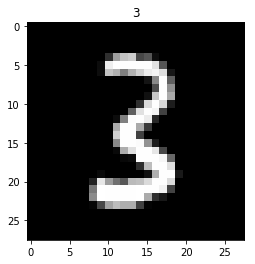

In [10]:
show(x_imgs[0], y_valid[0])

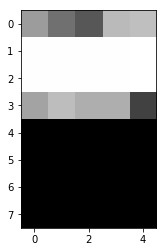

In [11]:
show(x_imgs[0,20:28,10:15])

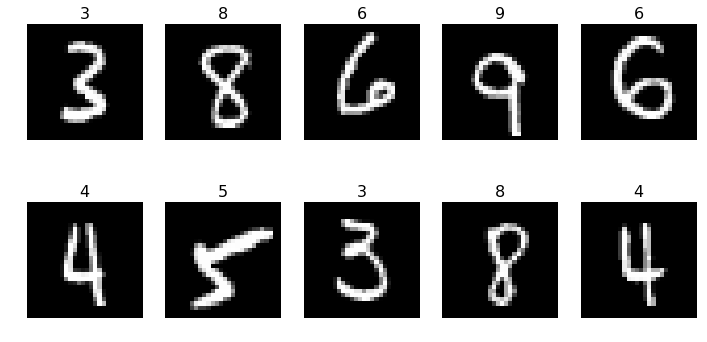

In [12]:
plots(x_imgs[:10], rows=2, titles=y_valid[:10])

### Neural network

In [13]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

In [14]:
net = nn.Sequential(
    nn.Linear(28*28,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,10),
    nn.LogSoftmax()
)

In [15]:
md = ImageClassifierData.from_arrays('./', (x,y), (x_valid, y_valid))

In [16]:
loss = nn.NLLLoss()
metrics = [accuracy]
opt = optim.SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

In [17]:
set_lrs(opt, 1e-2)

In [18]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics);

epoch      trn_loss   val_loss   accuracy                     
    0      0.194471   0.152285   0.9564    
    1      0.115262   0.11359    0.9666                       
    2      0.081599   0.106739   0.9675                        
    3      0.076181   0.091871   0.972                         
    4      0.065084   0.090369   0.973                         



In [19]:
??set_lrs

In [20]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])

In [21]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)
        self.l1_b = get_weights(10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.matmul(x, self.l1_w) + self.l1_b
        x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=0)))
        return x

In [22]:
net2 = LogReg()

In [23]:
opt = optim.Adam(net2.parameters())

In [24]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                    
    0      2.440928   2.411295   0.9095    



[array([2.4113]), 0.9095]

In [25]:
dl = iter(md.trn_dl)

In [26]:
xmb, ymb = next(dl)

In [27]:
xmb


-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
          ...             ⋱             ...          
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
[torch.FloatTensor of size 64x784]

<b>Note: </b>Inbuild data reader in fastai uses mini-batch size of 64

In [28]:
vxmb = Variable(xmb)
vxmb

Variable containing:
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
          ...             ⋱             ...          
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
[torch.FloatTensor of size 64x784]

In [30]:
preds = net2(vxmb).exp(); 
preds

Variable containing:

Columns 0 to 5 
 1.0866e-04  1.9281e-06  1.4355e-04  2.2922e-05  2.2923e-04  6.0590e-04
 5.9632e-04  3.7857e-03  7.8332e-04  7.0754e-03  2.0736e-03  3.2076e-02
 8.0251e-04  1.2730e-02  8.5544e-03  8.1373e-03  1.0541e-03  1.1919e-02
 1.1902e-03  1.4247e-03  1.3543e-03  4.5375e-02  7.7835e-04  4.4165e-03
 3.1345e-04  6.9316e-04  1.9294e-03  2.1231e-03  4.5100e-03  1.9038e-03
 4.2373e-03  3.0771e-04  4.2802e-04  3.1726e-01  1.8457e-04  2.2782e-02
 8.6995e-04  2.2788e-05  7.2235e-06  8.1341e-03  7.8657e-03  6.0227e-02
 1.2605e-03  1.2139e-04  6.6753e-03  3.3179e-04  4.2908e-04  2.7326e-03
 1.5416e-03  1.9234e-06  1.9671e-03  8.7426e-05  1.6951e-01  5.1540e-04
 1.1587e-04  2.5103e-01  4.2614e-03  3.4934e-03  1.9080e-03  2.2836e-03
 2.5007e-03  1.4795e-03  9.3980e-04  1.9501e-03  2.4693e-03  1.5460e-01
 4.4563e-05  2.6780e-04  5.8364e-04  2.4437e-03  7.6685e-04  1.0526e-03
 1.8360e-03  4.1513e-06  5.0354e-02  4.9219e-03  2.7546e-04  6.0382e-04
 8.0820e-04  1.4573e-03  1

In [31]:
preds.max(1)[1]

Variable containing:
 8
 8
 6
 8
 8
 3
 5
 6
 4
 1
 5
 7
 2
 8
 3
 4
 6
 2
 2
 0
 5
 9
 3
 4
 4
 2
 7
 5
 2
 0
 3
 6
 6
 2
 1
 0
 0
 1
 9
 9
 7
 9
 8
 9
 4
 6
 9
 6
 9
 1
 7
 2
 2
 8
 6
 5
 0
 9
 3
 6
 1
 2
 0
 9
[torch.LongTensor of size 64]

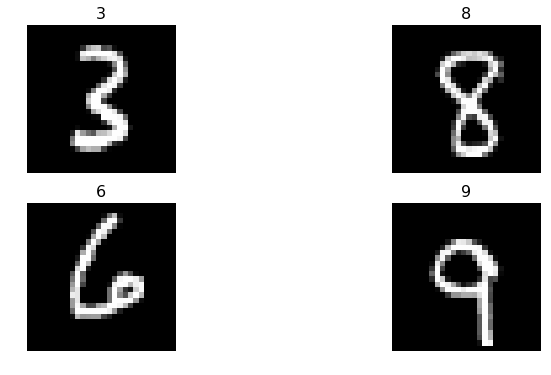

In [32]:
preds = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:4], titles=preds[:4])

#### Numpy Broadcasting

In [33]:
a = np.array([[10,20,30],
              [10,20,30],
              [10,20,30]])

In [34]:
b = np.array([10,20,30])

In [35]:
a+b

array([[20, 40, 60],
       [20, 40, 60],
       [20, 40, 60]])

In [36]:
a + b.T

array([[20, 40, 60],
       [20, 40, 60],
       [20, 40, 60]])

In [37]:
b.T

array([10, 20, 30])

In [38]:
a + np.expand_dims(b, 1)

array([[20, 30, 40],
       [30, 40, 50],
       [40, 50, 60]])

In [39]:
np.broadcast_to(b[None,:] , (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [40]:
np.broadcast_to(b[:, None] , (3,3))

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

In [46]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)
        self.l1_b = get_weights(10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.matmul(x, self.l1_w) + self.l1_b
        x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=0)))
        return x
    
net2 = LogReg()
opt = optim.Adam(net2.parameters())

fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                    
    0      2.450824   2.409142   0.91      



[array([2.40914]), 0.91]

In [48]:
net2 = LogReg()
loss = nn.NLLLoss()
learning_rate = 1e-3
optimizer = optim.Adam(net2.parameters(), lr=learning_rate)

In [49]:
dl = iter(md.trn_dl)

In [50]:
xt, yt = next(dl)

In [51]:
y_pred = net2(Variable(xt))

In [53]:
l = loss(y_pred, Variable(yt))
print(l)

Variable containing:
 4.1507
[torch.FloatTensor of size 1]



In [54]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.15625

In [55]:
optimizer.zero_grad()
l.backward()
optimizer.step()

In [56]:
xt, yt = next(dl)
y_pred = net2(Variable(xt))
l = loss(y_pred, Variable(yt))
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.59375

Accuracy changed from 15.6% to 59.3%

In [60]:
for t in range(100):
    xt, yt = next(dl)
    y_pred = net2(Variable(xt))
    l = loss(y_pred, Variable(yt))
    
    if t % 10 == 0:
        accuracy = np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))
        print("loss: ", l.data[0], "\t accuracy: ", accuracy)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

loss:  2.652348041534424 	 accuracy:  0.859375
loss:  2.508136510848999 	 accuracy:  0.875
loss:  2.550856113433838 	 accuracy:  0.875
loss:  2.473738670349121 	 accuracy:  0.828125
loss:  2.673726797103882 	 accuracy:  0.828125
loss:  2.5971269607543945 	 accuracy:  0.921875
loss:  2.6513471603393555 	 accuracy:  0.78125
loss:  2.7475571632385254 	 accuracy:  0.796875
loss:  2.583475112915039 	 accuracy:  0.796875
loss:  2.478987693786621 	 accuracy:  0.875


In [59]:
optimizer = optim.Adam(net2.parameters(), lr=1e-6)

Manually define optimizer step function as: <br>
w.data -= w.grad.data * lr<br>
b.data -= b.grad.data * lr<br>
to get SGD (without momentum)        